# House Prices
### Advanced Regression Techniques

Taking in the dataset we process the data through multiple regression techniques and narrow down the important details in the data set to improve the score of the housing price.

### Initial Data Exploration
The first step is to read the data so that we can build a initial idea of the data therefore being able to make informed decisions later on.

As we look the dataset we see if there are any interesting variables that we can further test on. 

Looking at the dataset there are alot of categorical features (i.e MoSold) and the opposite, quality measures (i.e GarageArea). As well as these, there can be many empty variables found too, later on we will remove these so that it doesnt interfere with our results.

After doing this we load the dataset into the notebook to start working on.

In [1]:
import numpy as np
import pandas as pd
import math
from scipy import stats

In [2]:
train = pd.read_csv('./train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

As we previously viewed the dataset, as expected there are missing values and some with few values at all. 

Removing them is an option to reduce errors or even setting them to zero.

### Basic Correlations
Below is a heatmap plot, they are a good visual aid in seeing information about the data.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

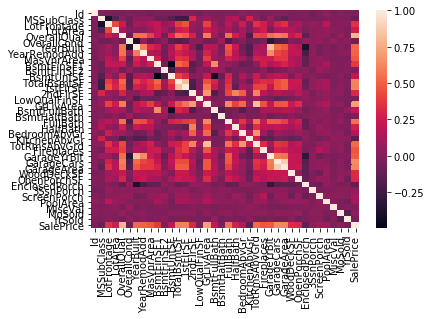

<Figure size 432x288 with 0 Axes>

In [4]:
data=train.corr()
sns.heatmap(data, xticklabels=data.columns, yticklabels=data.columns)
plt.show()
plt.gcf().clear()

ID does not show any correlation, but other factors such as YrSold which as a few correlations with other variables. ##add more

### Skews

Recall the form of a standard linear regression

\begin{align}
\ y & = ax_1 + bx_2 + cx_3 \\
\end{align}
 
We have a dependant ( *y* ) which needs to be proportional to other variable which would be an issue if ( *y* ) is skewed. This shouldnt affect some regressors but might affect othres.

Below are the skews.

In [5]:
train.skew()

Id                0.000000
MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

The main variable SalePrice is skewed slightly which will be an issue which will need to be addressed.

### Making a Baseline Model

We have found a few different things that we need to attempt:

* Correcting Missing Values
* Converting Categorical variables into numerical.
* Converting Numerical varibles into Categorical.

as well as

* Unskewing variables.

As a ininital benchmark of the data this way we can see if we are improving our data.

### Train
First of we create a copy of the data and turn the categorical data into dummy variables.

In [6]:
train_d = train.copy()
train_d = pd.get_dummies(train_d)

Now we remove the original categorical variables.

In [7]:
keep_cols = train_d.select_dtypes(include=['number']).columns
train_d = train_d[keep_cols]

Now we fill any non-applicables with mean values

In [8]:
train_d = train_d.fillna(train_d.mean())

### Test

In [9]:
test = pd.read_csv('test.csv')

In [10]:
test_d = test.copy()
test_d = pd.get_dummies(test_d)

In [11]:
test_d = test_d.fillna(test_d.mean())

Any dummy variable that exsist in the training set but test are being added in t he following code below.

In [12]:
for col in keep_cols:
    if col not in test_d:
        test_d[col] = 0

In [13]:
test_d = test_d[keep_cols]

### Modelling
We are going to use a random forest regressor, this will somewhat remove the dependancy on skews that we have with the linear regression. Random Forest regressors tend to preform well in general as a base.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [15]:
rf_test = RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, random_state=1234)
cv_score = cross_val_score(rf_test, train_d.drop('SalePrice', axis = 1), train_d['SalePrice'], cv = 5, n_jobs = -1)

In [16]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8687310233980317


### First Pass on the data
We looked at the data and identified a few variables that would be worth addressing.

LotFrontage could affect the performance of the regressions down the line so inorder to counter this we will try using zeros for values that have no front lotage or use imputed medians from the other values.

##### Zeros

In [17]:
train_0 = train.copy()

In [18]:
null_index = train_0.LotFrontage.isnull()
train_0.loc[null_index, 'LotFrontage'] = 0

In [19]:
train_0 = pd.get_dummies(train_0)

In [20]:
keep_cols = train_0.select_dtypes(include=['number']).columns
train_0 = train_0[keep_cols]

In [21]:
train_0 = train_0.fillna(train_0.mean())

In [22]:
rf_test = RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, n_jobs=-1, random_state=1234)
cv_score = cross_val_score(rf_test, train_0.drop('SalePrice', axis = 1), train_0['SalePrice'], cv = 5, n_jobs=-1)

In [23]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8666693800509881


The score is worse then the original score of (0.8687310233980317) so changing the values to zero does not help us in acheiveing anything imrpvoed.

##### Medians

Using medians we will assign a value that is proportional to the location of the house that way the values are not totally made up.

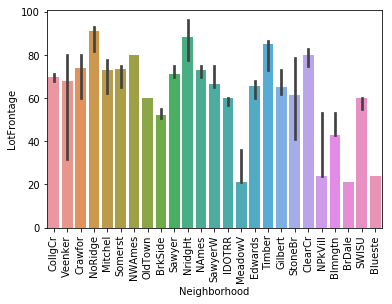

<Figure size 432x288 with 0 Axes>

In [24]:
sns.barplot(data=train,x='Neighborhood',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()
plt.gcf().clear()

In [25]:
gb_neigh_LF = train['LotFrontage'].groupby(train['Neighborhood'])

In [26]:
train_LFm = train.copy()

In [27]:
# for the key (the key is neighborhood in this case), 
# and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_LFm.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

Below we will test if that has improved anything

In [28]:
train_LFm = pd.get_dummies(train_LFm)

In [29]:
keep_cols = train_LFm.select_dtypes(include=['number']).columns
train_LFm = train_LFm[keep_cols]

In [30]:
train_LFm = train_LFm.fillna(train_LFm.mean())

In [31]:
rf_test = RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, n_jobs=-1, random_state= 1234)
cv_score = cross_val_score(rf_test, train_LFm.drop('SalePrice', axis = 1), train_LFm['SalePrice'], cv = 5, n_jobs=-1)

In [32]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8691510606990352


The score has improved but only marginally but we will stay with this method for now.

### Median vs Means
As an extra method of processing the data we will see if using means will improve the score any more.

In [33]:
train_med = train.copy()

In [34]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_med.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [35]:
train_med = pd.get_dummies(train_med)

In [36]:
keep_cols = train_med.select_dtypes(include=['number']).columns
train_med = train_med[keep_cols]

In [37]:
train_med = train_med.fillna(train_med.median())

In [38]:
rf_test = RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, n_jobs=-1, random_state=1234)
cv_score = cross_val_score(rf_test, train_med.drop('SalePrice', axis = 1), train_med['SalePrice'], cv = 5, n_jobs=-1)

In [39]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8699353054451968


### Numeric to Categoric
Now we will process that data that is in numerical values but should be in categorical these include

* MSSubClass
* MoSold
* YrSold

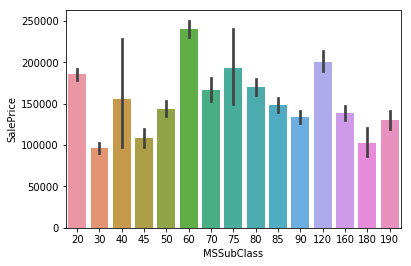

<Figure size 432x288 with 0 Axes>

In [40]:
sns.barplot(data=train, x='MSSubClass', y='SalePrice')
plt.show()
plt.gcf().clear()

The random forest regression is one of the slowest models to use so with the help of another kernal we are going to use another model in this case using XGBoost. 

In [41]:
from xgboost.sklearn import XGBRegressor

In [42]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_med.drop(['SalePrice','Id'], axis = 1), train_med['SalePrice'], cv = 5, n_jobs = -1)

In [43]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8876980252346718


This score is alot stronger so we will use XGBoost as our regressor from now on.

### Categoric to Numeric

Coverting some data from categoric to numeric may improve the score as the data could preformance better.

In [44]:
has_rank = [col for col in train if 'TA' in list(train[col])]

In [45]:
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

In [46]:
train_c2n = train.copy()

In [47]:
train_c2n['MSSubClass'] = train_c2n['MSSubClass'].astype('category')

In [48]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_c2n.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [49]:
for col in has_rank:
    train_c2n[col+'_2num'] = train_c2n[col].map(dic_num)

In [50]:
train_c2n = pd.get_dummies(train_c2n)

In [51]:
train_cols = train_c2n.select_dtypes(include=['number']).columns
train_c2n = train_c2n[train_cols]

In [52]:
train_c2n = train_c2n.fillna(train_c2n.median())

In [53]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_c2n.drop(['SalePrice','Id'], axis = 1), train_c2n['SalePrice'], cv = 5, n_jobs=-1)

In [54]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.894337472981583


Another increase using XGBoost and converting these values has proven to be a good.

Now we will introduce dropping columns of lower importantance.

In [55]:
from statistics import mode

In [56]:
low_var_cat = [col for col in train.select_dtypes(exclude=['number']) if 1 - sum(train[col] == mode(train[col]))/len(train) < 0.03]
low_var_cat

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

Lets remove these columns.

In [57]:
has_rank = [col for col in train if 'TA' in list(train[col])]

In [58]:
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

In [59]:
train_col = train.copy()

In [60]:
train_col = train_col.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis = 1)

In [61]:
train_col['MSSubClass'] = train_col['MSSubClass'].astype('category')

In [62]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_col.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [63]:
for col in has_rank:
    train_col[col+'_2num'] = train_col[col].map(dic_num)

In [64]:
train_col = pd.get_dummies(train_col)

In [65]:
train_cols = train_col.select_dtypes(include=['number']).columns
train_col = train_col[train_cols]

In [66]:
train_col = train_col.fillna(train_col.median())

In [67]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_col.drop(['SalePrice','Id'], axis = 1), train_col['SalePrice'], cv = 5, n_jobs=-1)

In [68]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.894846898565685


Not such as a increase as before but still substantial

### None vs NA
We removed the issue where NA values would be an issue by replacing them with medians however categoric values are still an issue because when we create dummy variables these get removed from the dataset.

If a value is missing we will replace it with the mode.

In [69]:
cat_hasnull = [col for col in train.select_dtypes(['object']) if train[col].isnull().any()]
cat_hasnull

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

Electrical being the only one which does not have NAs so we will remove it from the function.

In [70]:
cat_hasnull.remove('Electrical')

In [71]:
mode_elec = mode(train['Electrical'])
mode_elec

'SBrkr'

In [72]:
has_rank = [col for col in train if 'TA' in list(train[col])]

In [73]:
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

In [74]:
cat_hasnull = [col for col in train.select_dtypes(['object']) if train[col].isnull().any()]

In [75]:
cat_hasnull.remove('Electrical')

In [76]:
train_none = train.copy()

In [77]:
train_none = train_none.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis = 1)

In [78]:
train_none['MSSubClass'] = train_none['MSSubClass'].astype('category')

In [79]:
for col in cat_hasnull:
    null_idx = train_none[col].isnull()
    train_none.loc[null_idx, col] = 'None'

In [80]:
null_idx_el = train_none['Electrical'].isnull()
train_none.loc[null_idx_el, 'Electrical'] = 'SBrkr'

In [81]:
# for the key (the key is neighborhood in this case), and the group object (group is LotFrontage grouped by Neighborhood) 
# associated with it...
for key,group in gb_neigh_LF:
    # find where we are both simultaneously missing values and where the key exists
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    train_none.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [82]:
for col in has_rank:
    train_none[col+'_2num'] = train_none[col].map(dic_num)

In [83]:
train_none = pd.get_dummies(train_none)

In [84]:
train_cols = train_none.select_dtypes(include=['number']).columns
train_none = train_none[train_cols]

In [85]:
train_none = train_none.fillna(train_none.median())

In [86]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_none.drop(['SalePrice','Id'], axis = 1), train_none['SalePrice'], cv = 5, n_jobs=-1)

In [87]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.8959850608209289


Another increase, we can continue moving forward with the data processing.

### Unskewing Data

In [88]:
cols_skew = [col for col in train_none if '_2num' in col or '_' not in col]
train_none[cols_skew].skew()

Id                   0.000000
LotFrontage          2.212959
LotArea             12.207688
OverallQual          0.216944
OverallCond          0.693067
YearBuilt           -0.613461
YearRemodAdd        -0.503562
MasVnrArea           2.677616
BsmtFinSF1           1.685503
BsmtFinSF2           4.255261
BsmtUnfSF            0.920268
TotalBsmtSF          1.524255
1stFlrSF             1.376757
2ndFlrSF             0.813030
LowQualFinSF         9.011341
GrLivArea            1.366560
BsmtFullBath         0.596067
BsmtHalfBath         4.103403
FullBath             0.036562
HalfBath             0.675897
BedroomAbvGr         0.211790
KitchenAbvGr         4.488397
TotRmsAbvGrd         0.676341
Fireplaces           0.649565
GarageYrBlt         -0.678333
GarageCars          -0.342549
GarageArea           0.179981
WoodDeckSF           1.541376
OpenPorchSF          2.364342
EnclosedPorch        3.089872
3SsnPorch           10.304342
ScreenPorch          4.122214
PoolArea            14.828374
MiscVal   

Values that are above 1 tend to preform better when processing them.

In [89]:
cols_unskew = train_none[cols_skew].columns[abs(train_none[cols_skew].skew()) > 1]

In [90]:
train_unskew = train_none.copy()

In [91]:
for col in cols_unskew:
    train_unskew[col] = np.log1p(train_none[col])

In [92]:
xgb_test = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(xgb_test, train_unskew.drop(['SalePrice','Id'], axis = 1), train_unskew['SalePrice'], cv = 5, n_jobs=-1)

In [93]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.9101882241309056


This is a large increase in our score which would mean that unskewing the data makes it more predictable by XGBoost.

### Different Model
Trying the same model will produce simular results no matter what so trying a new model could improve the score even more, in this case we will try Lasoo which is a linear model

In [94]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [95]:
scaler = StandardScaler()
LCV = LassoCV()
scale_LCV = Pipeline([('scaler',scaler),('LCV',LCV)])

cv_score = cross_val_score(scale_LCV, train_unskew.drop(['SalePrice','Id'], axis = 1), train_unskew['SalePrice'], cv = 5, n_jobs=-1)

In [96]:
print('CV Score is: '+ str(np.mean(cv_score)))

CV Score is: 0.9035868593557363


The score is lower but the CV shouldnt be relied on as by submitting the results, it has beaten the score of the XGBoost.

In [97]:
scale_LCV.fit(train_unskew.drop(['SalePrice','Id'], axis = 1), train_unskew['SalePrice'])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LCV', LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

In [98]:
lasso_w = scale_LCV.named_steps['LCV'].coef_
cols= train_unskew.drop(['SalePrice','Id'], axis=1).columns

In [99]:
cols_w = pd.DataFrame()
cols_w['Features'] = cols
cols_w['LassoWeights'] = lasso_w
cols_w['LassoWeightsMag'] = abs(lasso_w)

In [100]:
cols_w[cols_w.LassoWeights==0]

,Features,LassoWeights,LassoWeightsMag
0,LotFrontage,0.0,0.0
6,MasVnrArea,0.0,0.0
8,BsmtFinSF2,-0.0,0.0
9,BsmtUnfSF,-0.0,0.0
12,2ndFlrSF,0.0,0.0
13,LowQualFinSF,-0.0,0.0
16,BsmtHalfBath,0.0,0.0
19,BedroomAbvGr,0.0,0.0
21,TotRmsAbvGrd,0.0,0.0
23,GarageYrBlt,0.0,0.0


The following did not get removed from the dataset during the Lasso regression.

Below are the top 5 important variables.

In [101]:
top5_feats = list(cols_w.sort_values(by='LassoWeightsMag',ascending=False)[:5].Features)

In [102]:
def print_scatters(df_in, cols, against):   
    plt.figure(1)
    # sets the number of figure row (ie: for 10 variables, we need 5, for 9 we 
    # need 5 as well)
    rows = math.ceil(len(cols)/2)
    f, axarr = plt.subplots(rows, 2, figsize=(10, rows*3))
    # for each variable you inputted, plot it against the dependant
    for col in cols:
        ind = cols.index(col)
        i = math.floor(ind/2)
        j = 0 if ind % 2 == 0 else 1
        if col != against:
            sns.regplot(data = df_in, x=col, y=against, fit_reg=False, ax=axarr[i,j])
        else:
            sns.distplot(a = df_in[col], ax=axarr[i,j])
        axarr[i, j].set_title(col)
    f.text(-0.01, 0.5, against, va='center', rotation='vertical', fontsize = 12)
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

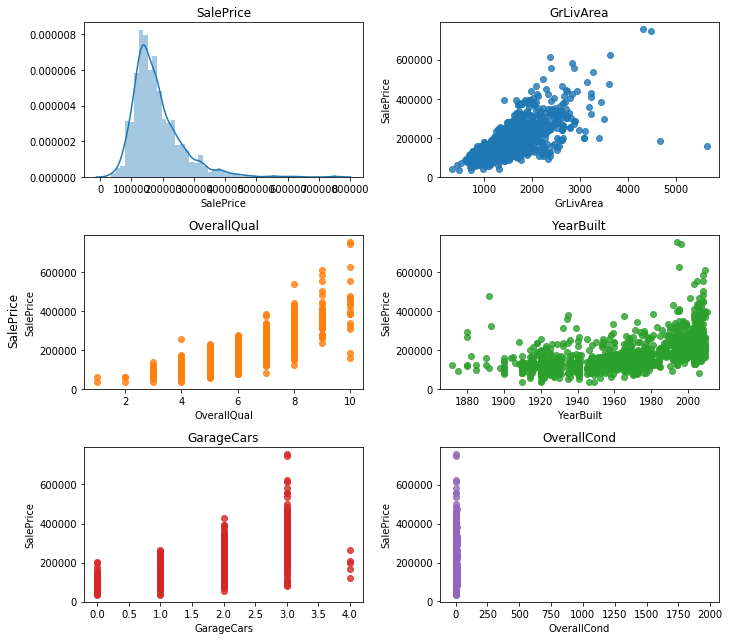

<Figure size 432x288 with 0 Axes>

In [103]:
print_scatters(df_in=train,cols=['SalePrice']+top5_feats,against='SalePrice')

### Final Steps

In [104]:
train_test_raw = train.append(test)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [105]:
lot_frontage_by_neighborhood_all = train_test_raw["LotFrontage"].groupby(train_test_raw["Neighborhood"])

In [106]:
has_rank = [col for col in train if 'TA' in list(train[col])]

In [107]:
dic_num = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

In [108]:
cat_hasnull = [col for col in train.select_dtypes(['object']) if train[col].isnull().any()]

In [109]:
cat_hasnull.remove('Electrical')

In [110]:
train_c2n = train.copy()

In [111]:
for key,group in lot_frontage_by_neighborhood_all:
    lot_f_nulls_nei = train['LotFrontage'].isnull() & (train['Neighborhood'] == key)
    train_c2n.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [112]:
train_c2n = train_c2n.drop(['Street','Utilities','Condition2','RoofMatl','Heating'], axis=1)

In [113]:
train_c2n['MSSubClass'] = train_c2n['MSSubClass'].astype('category')

In [114]:
for col in cat_hasnull:
    null_idx = train_c2n[col].isnull()
    train_c2n.loc[null_idx, col] = 'None'

In [115]:
null_idx_el = train_c2n['Electrical'].isnull()
train_c2n.loc[null_idx_el, 'Electrical'] = 'SBrkr'

In [116]:
for col in has_rank:
    train_c2n[col+'_2num'] = train_c2n[col].map(dic_num)

In [117]:
train_c2n = pd.get_dummies(train_c2n)

In [118]:
train_cols = train_c2n.select_dtypes(include=['number']).columns
train_c2n = train_c2n[train_cols]

##### Test Set

In [119]:
test_c2n = test.copy()

In [120]:
# See Human Analog
test_c2n.loc[666, "GarageQual"] = "TA"
test_c2n.loc[666, "GarageCond"] = "TA"
test_c2n.loc[666, "GarageFinish"] = "Unf"
test_c2n.loc[666, "GarageYrBlt"] = 1980

test_c2n.loc[1116,'GarageType'] = np.nan

In [121]:
for key,group in lot_frontage_by_neighborhood_all:
    lot_f_nulls_nei = test['LotFrontage'].isnull() & (test['Neighborhood'] == key)
    test_c2n.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

In [122]:
test_c2n = test_c2n.drop(['Street','Utilities','Condition2','RoofMatl','Heating'], axis=1)

In [123]:
test_c2n['MSSubClass'] = test_c2n['MSSubClass'].astype('category')

In [124]:
for col in cat_hasnull:
    null_idx = test_c2n[col].isnull()
    test_c2n.loc[null_idx, col] = 'None'

In [125]:
null_idx_el = test_c2n['Electrical'].isnull()
test_c2n.loc[null_idx_el, 'Electrical'] = 'SBrkr'

In [126]:
for col in has_rank:
    test_c2n[col+'_2num'] = test_c2n[col].map(dic_num)

In [127]:
test_c2n = pd.get_dummies(test_c2n)

In [128]:
test_c2n['SalePrice'] = 0

In [129]:
for col in train_cols:
    if col not in test_c2n:
        train_c2n = train_c2n.drop(col,axis=1)

In [130]:
test_c2n = test_c2n.drop('MSSubClass_150', axis = 1)

In [131]:
final_cols = test_c2n.select_dtypes(include=['number']).columns
test_c2n = test_c2n[final_cols]

In [132]:
test_c2n = test_c2n[train_c2n.columns]

##### Fill with Medians

In [133]:
train_test_combo = train_c2n.append(test_c2n)
train_test_raw = train.append(test)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [134]:
train_test_combo = train_test_combo.fillna(train_test_combo.median())

In [135]:
train_med = train_test_combo[:1460]
test_med = train_test_combo[1460:]

##### Unskewing

In [136]:
cols = [col for col in train_med if '_2num' in col or '_' not in col]
skew = [abs(stats.skew(train_med[col])) for col in train_med if '_2num' in col or '_' not in col]

In [137]:
skews = pd.DataFrame()
skews['Columns'] = cols
skews['Skew_Magnintudes'] = skew

In [138]:
cols_unskew = skews[skews.Skew_Magnintudes > 1].Columns

In [139]:
train_unskew2 = train_med.copy()
test_unskew2 = test_med.copy()

In [140]:
for col in cols_unskew:
    train_unskew2[col] = np.log1p(train_med[col])
    
for col in cols_unskew:
    test_unskew2[col] = np.log1p(test_med[col])

In [141]:
bonf_outlier = [88,462,523,588,632,968,1298,1324]

In [142]:
train_unskew3 = train_unskew2.drop(bonf_outlier)

##### Overfit Columns

In [143]:
drop_cols = ["MSSubClass_160", "MSZoning_C (all)"]

In [144]:
train_unskew3 = train_unskew3.drop(drop_cols, axis = 1)
test_unskew2 = test_unskew2.drop(drop_cols, axis = 1)

##### Final DF

In [145]:
X_train = train_unskew3.drop(['Id','SalePrice'],axis = 1)
y_train = train_unskew3['SalePrice']

In [146]:
X_test = test_unskew2.drop(['Id','SalePrice'],axis=1)

### Final Modelling


In [147]:
from sklearn.base import BaseEstimator, RegressorMixin

In [148]:
class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append((regressor.predict(X).ravel()))
        return (np.mean(self.predictions_, axis=0))

In [149]:
xgb1 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200
                )

xgb2 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200,
                seed = 1234
                )

xgb3 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=1200,
                seed = 1337
                )

In [150]:
xgb_ens = CustomEnsembleRegressor([xgb1,xgb2,xgb3])

In [151]:
cvscore = cross_val_score(cv=5,estimator=xgb1,X = X_train,y = y_train, n_jobs = -1)

In [152]:
print('CV Score is: '+ str(np.mean(cvscore)))

CV Score is: 0.9239038884214372


### Submission

In [153]:
xgb_ens.fit(X_train, y_train);
scale_LCV.fit(X_train,y_train);

In [154]:
preds_x = np.expm1(xgb_ens.predict(X_test));
preds_l = np.expm1(scale_LCV.predict(X_test));
preds = (preds_x+preds_l)/2
out_preds = pd.DataFrame()
out_preds['Id'] = test['Id']
out_preds['SalePrice'] = preds
out_preds.to_csv('output.csv', index=False)